# Produce Plots for Publication

Use self built surface classification library `surface_classify` available at https://github.com/FelixWodaczek/surface_classify.git.

## Imports

In [1]:
import sys
sys.path.append("../py_src")

from glob import glob
import os

import numpy as np
import matplotlib.pyplot as plt

import sort_neigh

from ase.io import read as ase_read
from ase.neighborlist import natural_cutoffs, NeighborList

## Standard Values

In [14]:
target_dir = "/Users/rhysbunting/Documents/itistime"
n_particles = 1577
n_rhod = 15

rcut=5.2 # 4.2
nmax=12
lmax=12
sigma=2
gamma_kernel=1

## Figure 1, Available Sites on Nanoparticle

Analyse the available sites in a nanoparticle containing only Rh.

### Define Target

In [15]:
only_cu_dir = target_dir + "/cunanoparticle"
only_cu_path = only_cu_dir + "/cusingle.lammpstrj"

In [16]:
scaled_structures_path = os.path.abspath("../src/localstructures_newopt_onlyCu_altered")

cu_classifier = sort_neigh.onlyCuClassifier(
    local_structures_path=scaled_structures_path, non_class_max=12
)
cu_classifier.load_identifiers(
    rcut=rcut, nmax=nmax, lmax=lmax, 
    sigma=sigma, gamma_kernel=gamma_kernel,
)

rh_classifier = sort_neigh.NeighbourClassifier(local_structures_path=os.path.abspath("../src/localstructures"))
rh_classifier.load_identifiers(
    rcut=rcut, nmax=nmax, lmax=lmax, 
    sigma=sigma, gamma_kernel=gamma_kernel,
)

### Run Analysis via Classifier
Use the surface classifier to determine what sites are identified at which position.

In [ ]:
mode="class_all"

full_particle = ase_read(only_cu_path)
at_pos = full_particle.get_positions()

cut_off = natural_cutoffs(full_particle, mult=0.98)# mult=0.98)
neighbour_list = NeighborList(cut_off, bothways=True, self_interaction=False)
neighbour_list.update(full_particle)

cu_cat_counter = np.zeros(shape=(cu_classifier.n_classes), dtype=np.int32)
categories = np.zeros((len(full_particle),), dtype=np.int32)
neighbours = np.zeros((len(full_particle),), dtype=np.int32)

ind_soaps = np.zeros((len(full_particle), cu_classifier.soap.get_number_of_features()))
for index in range(len(full_particle)):
    neighbour_indices, trash = neighbour_list.get_neighbors(index)
    neighbour_indices = np.append(np.array([index]), neighbour_indices, axis=0)
    neighbour_particle = full_particle[neighbour_indices]
    
    ind_soaps[index] = cu_classifier.soap.create(neighbour_particle, positions=[0])
    n_neigh, class_id = cu_classifier.classify(neighbour_particle, mode=mode, ensure_position=False)

    cu_cat_counter[class_id] += 1
    neighbours[index] = int(n_neigh)
    categories[index] = int(class_id)

### Unsupervised Machine Learning
Use unsupervised ML to perform the same task and compare results afterwards

In [6]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, KernelPCA
from sklearn.cluster import KMeans, DBSCAN, Birch
from dscribe.descriptors import SOAP

ml_classifier = sort_neigh.USMLClassifier()

train_on_particle = True
if train_on_particle:
    n_clust = ml_classifier.train_on_particle(
        full_particle,
        soap_species=["Cu"], dim_red=PCA(n_components=4), clusterer=Birch(n_clusters=8),
        rcut=rcut, nmax=nmax, lmax=lmax, sigma=sigma,
    )
else:
    n_clust = ml_classifier._train_on_data(
        ind_soaps,
        dim_red=PCA(n_components=20), clusterer=Birch(n_clusters=8)
    )
    ml_classifier.soaper = cu_classifier.soap

soaps = ml_classifier.soaper.create(full_particle)
reduced = ml_classifier.dim_red.transform(soaps)

### Plotting
Create view of nanoparticle and reduced mapping for Paper

In [12]:
def norm_categories(a_categories, labels=None):
    c_range = np.arange(np.max(a_categories), np.min(a_categories)-2, -1)
    if labels is not None and len(c_range)-1 != len(labels):
        raise ValueError("Range of argument 'counter' needs to be same length as argument 'labels' if given.")
        
    ret_cats = a_categories.copy()
    
    if labels is not None:
        ret_labels = labels.copy()
    
    reduce_at_this = False
    for value_index, value in enumerate(c_range):
        reduce_at_next = value not in ret_cats
        
        if reduce_at_this:
            largereq_than_last = ret_cats > value
            ret_cats[largereq_than_last] -= 1
            if labels is not None:
                ret_labels.pop(len(c_range)-value_index-1)

        reduce_at_this = reduce_at_next
        
    ret_cats -= np.min(ret_cats)
    return ret_cats, ret_labels

        
def cmap_from_categories(colors, or_map_name="tab20", n_orcolors=20):
    c_range = np.max(colors)-np.min(colors)+1
    normed_colors = (colors-np.min(colors))/(c_range-1)
    normed_colors *= (c_range-1)/(c_range)
    normed_colors += 1./(2*c_range)

    c_ticks = np.linspace(0, 1, c_range*2+1, endpoint=True)[1::2]

    tab20 = cm.get_cmap(or_map_name, 256)
    color_range = np.linspace(0, c_range/float(n_orcolors), 500, endpoint=False)
    cmap = ListedColormap(tab20(color_range))
    
    return normed_colors, cmap, c_ticks


In [13]:
from matplotlib import cm
from matplotlib.colors import ListedColormap

%matplotlib auto
plt.ion()

cond = np.s_[...] # neighbours < 17

colors = categories[cond].copy()

c_labels = np.arange(np.min(colors), np.max(colors)+1)
c_labels = [cu_classifier.id_to_cat(c_label) for c_label in c_labels]

order_by_neighbors = True
if order_by_neighbors:
    colors[colors==np.min(colors)] = np.max(colors) + 1
    colors[colors==np.min(colors)] = np.max(colors) + 1
    c_labels.append(c_labels[0])
    c_labels.append(c_labels[1])
    c_labels.pop(0)
    c_labels.pop(0)
    
    while(len(c_labels) != np.max(colors) + 1 - np.min(colors)):
          c_labels.pop(0)
    
cont_values, c_labels = norm_categories(colors, labels=c_labels)
cat_clabels = c_labels.copy()

cat_normed_colors, cat_cmap, cat_cticks = cmap_from_categories(cont_values, or_map_name='tab10', n_orcolors=10)

label_color_dict = {c_label: color for c_label, color in zip(c_labels, cat_cticks)}

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(projection='3d')

sc = ax.scatter(
    at_pos[cond, 0], at_pos[cond, 1], at_pos[cond, 2], c=cat_normed_colors, cmap=cat_cmap, alpha=1,
    s=800, edgecolors="k", vmin=0, vmax=1
)

cbar = fig.colorbar(sc) 
cbar.set_ticks(cat_cticks)
cbar.set_ticklabels(c_labels)
plt.tight_layout()
fig.savefig("threed_particle.pdf", format='pdf')
plt.show()

Using matplotlib backend: MacOSX


In [9]:
soaps_from_classifier = []
labels = []

for key in cu_classifier.identification_dict.keys():
    entry = cu_classifier.identification_dict[key]
    if entry is not None:
        soaps_from_classifier.append(entry["soap_descr"][:, 0, :])
        labels.append(entry["id"])

buff = soaps_from_classifier[0].copy()
for ii_soap in range(1, len(soaps_from_classifier)):
    buff = np.append(buff, soaps_from_classifier[ii_soap], axis=0)

soaps_from_classifier = buff.copy()
del buff

buff = []
for label in labels:
    for entry in label:
        buff.append(entry)

labels=buff
del buff

soap_prediction = ml_classifier.dim_red.transform(soaps_from_classifier)

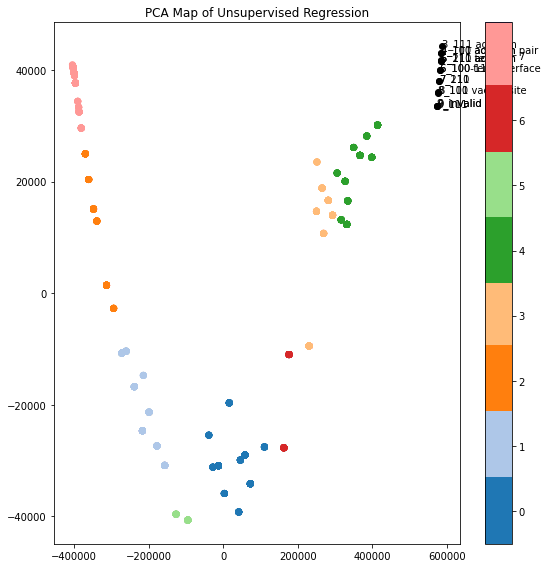

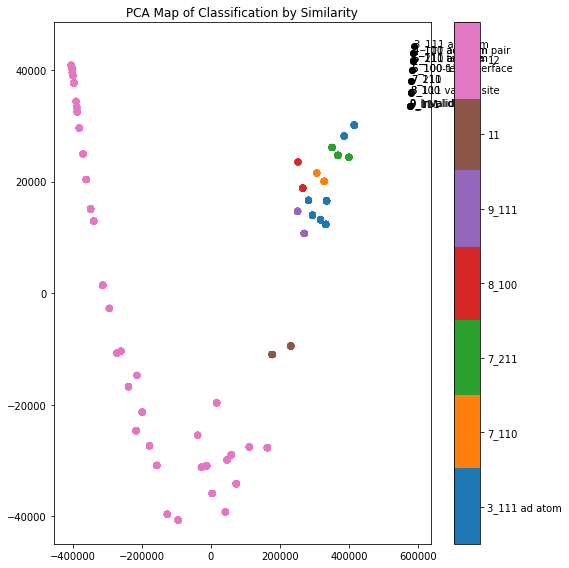

In [10]:
compare_soaps = True

%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.set_title("PCA Map of Unsupervised Regression")
c_labels = np.arange(np.min(n_clust), np.max(n_clust)+1)
normed_colors, cmap, c_ticks = cmap_from_categories(n_clust)

sc = ax.scatter(reduced[:, 0], reduced[:, 1], c=normed_colors, cmap=cmap, vmin=0, vmax=1)

if compare_soaps:
    ax.scatter(soap_prediction[:, 0], soap_prediction[:, 1], c="k")

    for ii_label, label in enumerate(labels):  
        ax.annotate(label, soap_prediction[ii_label, 0:2])
    
cbar = fig.colorbar(sc)
cbar.set_ticks(c_ticks)
cbar.set_ticklabels(c_labels)
plt.tight_layout()
fig.savefig("unsupervised_ml_pca.pdf", format='pdf')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.set_title("PCA Map of Classification by Similarity")
sc = ax.scatter(reduced[:, 0], reduced[:, 1], c=cat_normed_colors, cmap=cat_cmap, vmin=0, vmax=1)

if compare_soaps:
    ax.scatter(soap_prediction[:, 0], soap_prediction[:, 1], c="k")
    for ii_label, label in enumerate(labels):  
        ax.annotate(label, soap_prediction[ii_label, 0:2])
    
cbar = fig.colorbar(sc) 
cbar.set_ticks(cat_cticks)
cbar.set_ticklabels(cat_clabels)
plt.tight_layout()
fig.savefig("classification_pca.pdf", format='pdf')
plt.show()

## Figure 2, Rh Positions over Time
After defining all the available positions in the nanoparticle, analyse where the Rh sit in each timestep.

### Run Evaluation on Files
Set `newcats` to `True` to rerun evaluation, otherwise pre-existing evaluation is loaded from .txt files.

In [ ]:
target_folders = [
    target_dir+"/mc",
    target_dir+"/mcmd"
]

results_dict = {}

newcats = False
for target_folder in target_folders:
    for target_file in glob(target_folder+"/*.lammpstrj"):
        target_file = os.path.abspath(target_file)
        only_file = os.path.basename(target_file).split(".")[0]
        out_dir = os.path.join(os.path.dirname(target_file), only_file+"_out")
        save_txt_path = os.path.join(os.path.dirname(target_file), only_file+"_out.txt")
        
        dir_name = save_txt_path.split("/")[-2]
        cur_key = '_'.join([dir_name, only_file])
        results_dict[cur_key] = {}
        
        rh_sorter = sort_neigh.NeighbourSort(
            rcut=rcut, nmax=nmax, lmax=lmax, 
            sigma=sigma, gamma_kernel=gamma_kernel
        )
        
        if newcats:
            rh_sorter.init_folder_structure(
                target_file,
                n_atoms_in_part=n_particles,
                out_dir=out_dir
            )
            rh_cats = rh_sorter.create_local_structure(last_n=n_rhod, create_subfolders=False)
            rh_sorter.sort_save_cat(save_txt_path, rh_cats)
        
        sorted_counts, timesteps, sorted_cats = rh_sorter.load_sort_cat(save_txt_path)
        
        results_dict[cur_key]["sorted_counts"] = sorted_counts
        results_dict[cur_key]["timesteps"] = timesteps
        results_dict[cur_key]["sorted_cats"] = sorted_cats

### Plot Raw Results

In [ ]:
counter = 0
for target_folder in target_folders:
    for target_file in glob(target_folder+"/*.lammpstrj"):
        target_file = os.path.abspath(target_file)
        only_file = os.path.basename(target_file).split(".")[0]
        out_dir = os.path.join(os.path.dirname(target_file), only_file+"_out")
        save_txt_path = os.path.join(os.path.dirname(target_file), only_file+"_out.txt")
        
        
        dir_name = save_txt_path.split("/")[-2]
        cur_key = '_'.join([dir_name, only_file])
        
        sorted_counts = results_dict[cur_key]["sorted_counts"] 
        timesteps = results_dict[cur_key]["timesteps"]
        sorted_cats = results_dict[cur_key]["sorted_cats"]
        
        fig_list, ax_list = rh_sorter.plot_dist(
            sorted_cats, sorted_counts, show_plot=False
        )
        
        print(cur_key)
        fig_list.pop(1)
        ax_list.pop(1)
        
        plt.show()
        counter += 1

### Plot Total Results

In [ ]:
total_sites = np.bincount(categories)
norm_dict = {}
for ii_site, n_site in enumerate(total_sites):
    norm_dict[cu_classifier.id_to_cat(ii_site)] = n_site
    print("Total number of %s: %u"%(cu_classifier.id_to_cat(ii_site), n_site))
    
for n_class in range(cu_classifier.n_classes):
    c_name = cu_classifier.id_to_cat(n_class)
    try:
        norm_dict[c_name]
    except:
        print(c_name)
        norm_dict[c_name] = 0


In [ ]:
%matplotlib inline

import matplotlib.patches as mpatches

fontsize=20

sorted_keys = []
for key in results_dict.keys():
    sorted_keys.append(key)
sorted_keys.sort()

norm_counter = True
plot_sidebyside = False

for ii_key, key in enumerate(sorted_keys):
    if ii_key%3 == 0:
        fig, axis = plt.subplots(figsize=(12,8))
        widths = np.array([-0.3, 0, 0.3])
        alphas = [0.2, 0.5, 1]
        
        sorted_cats = results_dict[key]["sorted_cats"]
        n_cats = len(sorted_cats)
        draw_cats = np.zeros((3, n_cats), dtype=np.float64)
        max_steps = 0
        
        for jj_cat_key, cat_keys in enumerate(sorted_keys[ii_key:ii_key+3]):
            cur_counts = results_dict[cat_keys]["sorted_counts"]
            draw_cats[jj_cat_key, :] = np.sum(cur_counts, axis=0)
            draw_cats[jj_cat_key, :] = draw_cats[jj_cat_key, :] / (cur_counts.shape[0] * n_rhod)
            draw_cats[jj_cat_key, :] *= 100
            assert np.sum(draw_cats[jj_cat_key, :]) == 100.

        total_cats = np.sum(draw_cats, axis=0)
        is_nonzero = total_cats != 0
        total_nonzero = np.sum(is_nonzero)
        x_locs = np.arange(total_nonzero)
        
        draw_cats = draw_cats[:, is_nonzero]
        
        not_zero_cats = []
        for ii_count, more_than_zero in enumerate(is_nonzero):
            if more_than_zero:
                not_zero_cats.append(sorted_cats[ii_count])
                
        new_colors_counter = 0
        not_zero_colors = []
        for nz_cat in not_zero_cats:
            try: # category is in previous cmap
                not_zero_colors.append(cat_clabels.index(nz_cat))
            except:
                not_zero_colors.append(len(cat_clabels)+new_colors_counter)
                new_colors_counter += 1
        
        not_zero_colors.append(0) # in first category is not in colors
            
        normed_colors, count_cmap, count_cticks = cmap_from_categories(not_zero_colors, or_map_name='tab10', n_orcolors=10)
        normed_colors = normed_colors[:-1]
        
        legend_patches = []
        for kk_draw in range(3):
            temperature = sorted_keys[ii_key+kk_draw].split('_')[-1]
            width = widths[kk_draw]
            draw_cat = draw_cats[kk_draw, :]
            
            if plot_sidebyside:
                side_xclocs = x_locs+(len(draw_cat)*kk_draw)+(1*kk_draw)
                axis.bar(
                    side_xclocs, draw_cat, width=1,
                    color=count_cmap(normed_colors), align='center'
                )
                annotation_cond = draw_cat != 0
                annotations = draw_cat[annotation_cond]
                for ll_ann, annotation in enumerate(annotations):
                    axis.annotate(
                        "%.4f"%annotation,
                        [side_xclocs[annotation_cond][ll_ann], annotation], 
                        ha='center', rotation=45, fontsize=fontsize-10
                    )
            else:
                axis.bar(
                    x_locs+width, draw_cat, width=0.3,
                    color=count_cmap(normed_colors), align='center', alpha=alphas[kk_draw]
                )
                annotation_cond = draw_cat != 0
                annotations = draw_cat[annotation_cond]
                for ll_ann, annotation in enumerate(annotations):
                    axis.annotate(
                        "%.4f"%annotation,
                        [x_locs[annotation_cond][ll_ann]+width, annotation], 
                        ha='center', rotation=45, fontsize=fontsize-10
                    )
            
            cur_patch = mpatches.Patch(
                color='k', label=temperature+" K", alpha=alphas[kk_draw]
            )
            legend_patches.append(cur_patch)
            
    
        axis.set_yscale('log')
        if plot_sidebyside:
            long_ticklocs = np.zeros((3*len(x_locs),))
            long_cats = []
            for mm_draw in range(3):
                long_ticklocs[mm_draw*len(x_locs):(mm_draw+1)*len(x_locs)] = x_locs+(len(draw_cat)*mm_draw)+(1*mm_draw)
                long_cats += not_zero_cats
            axis.set_xticks(long_ticklocs, long_cats, fontsize=fontsize-4, rotation=-45)
            axis.tick_params(axis='y', labelsize=fontsize-4)
        else:
            axis.set_xticks(x_locs, not_zero_cats, fontsize=fontsize-4)
            axis.tick_params(axis='y', labelsize=fontsize-4)
        axis.set_xlabel('site type', fontsize=fontsize)
        axis.set_ylabel('Rh atoms per surface type [%]', fontsize=fontsize)
        axis.set_ylim([axis.get_ylim()[0], 400])
        # axis.autoscale(tight=True)
        axis.legend(handles=legend_patches, fontsize=fontsize)
        
        plt.tight_layout()
        fig.savefig("barplot_%s.pdf"%key.split('_')[0], format="pdf")
        plt.show()